# Generating Weak Labels for Image Datasets (e.g. `Person Riding Bike`)

_Note_: This notebook assumes that Snorkel is installed. If not, see the [Quick Start guide](https://github.com/HazyResearch/snorkel#quick-start) in the Snorkel README.

---
In this tutorial, we write labeling functions over a set of unlabeled images to create a weakly-labeled dataset for **person riding bike**. 

1. **Load and visualize dataset** — Build intuition about heuristics and weak supervision for our task.
2. **Generate Primitives** — Writing labeling functions over raw image pixels is quite difficult for most tasks. Instead, we first create low level primitives (e.g. bounding box sizes/positions), which we can then write LFs over.
3. **Write Labeling Functions** — Express our heuristics as labeling functions over user-defined primitives.
4. **Generate Training Set** — Aggregate our heuristic-based lableing functions to create a training set using the Snorkel paradigm.

This process can be viewed as a way of leveraging off-the-shelf tools we already have (e.g. pretrained models, object detectors, etc.) for new tasks, which is very similar to the way we leveraged text processing tools in the other tutorials!

In this approach, we show that incorporating Snorkel's generative model for labeling function aggregation shows a significant lift in accuracy over majority vote. 

While the tutorial we show takes advantage of very basic primitives and models, there's a lot of room to experiment here. For more, see recent work ([Varma et. al 2017](https://arxiv.org/abs/1709.02477)) that incorporates static analysis + primitive dependencies to infer structure in generative models.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

_Note_: In this tutorial, we use `scikit-image`, which isn't a `snorkel` dependency. If you don't already have it installed, please run the following cell.

`wget top set of links from https://visualgenome.org/api/v0/api_home.html and put in the data/ folder`
install VG driver: `git+https://github.com/ranjaykrishna/visual_genome_python_driver.git@master`

`Our bounding box format is [ymin, ymax, xmin, xmax]. `

In [22]:
import json

objects = json.load(open("./data/VRD/objects.json"))
predicates = json.load(open("./data/VRD/predicates.json"))
semantic_predicates = ['carry', 'cover', 'fly', 'look', 'lying on', 'park on', 'sit on', 'stand on', 'ride']


relationships_train = json.load(open("./data/VRD/annotations_train.json"))
relationships_test = json.load(open("./data/VRD/annotations_test.json"))

np.random.seed(1234)
val_idx = list(np.random.choice(len(relationships_train), 1000, replace=False))
relationships_val = {key: value for i, (key, value) in enumerate(relationships_train.items()) if i in val_idx}
relationships_train = {key: value for i, (key, value) in enumerate(relationships_train.items()) if i not in val_idx}

print("Train Examples: ", len(relationships_train))
print("Dev Examples: ", len(relationships_val))
print("Test Examples: ", len(relationships_test))

Train Examples:  3000
Dev Examples:  1000
Test Examples:  1000


In [31]:
def flatten_vrd_relationship(img, relationship, objects, predicates):
    new_relationship_dict = {}
    new_relationship_dict['subject_category'] = objects[relationship['subject']['category']]
    new_relationship_dict['object_category'] = objects[relationship['object']['category']]
    new_relationship_dict['subject_bbox'] = relationship['subject']['bbox']
    new_relationship_dict['object_bbox'] = relationship['object']['bbox']

    new_relationship_dict['label'] = 1 if predicates[relationship['predicate']] == 'ride' else 2
    new_relationship_dict['source_img'] = img
    
    return new_relationship_dict

In [32]:
def vrd_to_pandas(relationships_set, objects, predicates, list_of_predicates=semantic_predicates):
    relationships = []

    for img in relationships_train:
        img_relationships = relationships_train[img]
        for relationship in img_relationships:
            predicate_idx = relationship['predicate']
            if predicates[predicate_idx] in list_of_predicates:
                relationships.append(flatten_vrd_relationship(img, relationship, objects, predicates))

    return pd.DataFrame.from_dict(relationships)

In [33]:
train_df = vrd_to_pandas(relationships_train, objects, predicates)
valid_df = vrd_to_pandas(relationships_val, objects, predicates)
test_df = vrd_to_pandas(relationships_test, objects, predicates)

In [34]:
# ride_keys = []
# other_keys = []

# for img in relationships_test:
#     img_relationships = relationships_test[img]
#     for relationship in img_relationships:
#         predicate_idx = relationship['predicate']
#         if predicates[predicate_idx] == 'ride':
#             ride_keys.append(img)
#         elif predicates[predicate_idx] in semantic_predicates:
#             other_keys.append(img)
            
# print("Number of ride relationships: ", len(ride_keys))
# print("Number of other relationships: ", len(other_keys))
# print("Percentage of Riding Relationships: ", len(ride_keys)/(len(ride_keys) + len(other_keys)))

In [ ]:
def LF_street(has_human, has_road):
    if has_human >= 1: 
        if has_road >= 1:
            return 1
        else:
            return -1
    return 0

def LF_vehicles(has_human, has_cars):
    if has_human >= 1: 
        if has_cars >= 1:
            return 1
        else:
            return -1
    return 0

def LF_distance(has_human, has_bike, bike_human_distance):
    if has_human >= 1:
        if has_bike >= 1: 
            if bike_human_distance <= np.sqrt(8):
                return 1
            else:
                return 0
    else:
        return -1
    
def LF_size(has_human, has_bike, bike_human_size):
    if has_human >= 1:
        if has_bike >= 1: 
            if bike_human_size <= 1000:
                return -1
            else:
                return 0
    else:
        return -1
    
    
def LF_number(has_human, has_bike, bike_human_num):
    if has_human >= 1:
        if has_bike >= 1: 
            if bike_human_num >= 2:
                return 1
            if bike_human_num >= 1:
                return 0
            if bike_human_num >= 0:
                return 1
    else:
        return -1

## 1. Load and Visualize Dataset
First, we load the dataset and associated bounding box objects and labels for people riding bikes.

We can visualize some **positive examples** of people riding bikes...

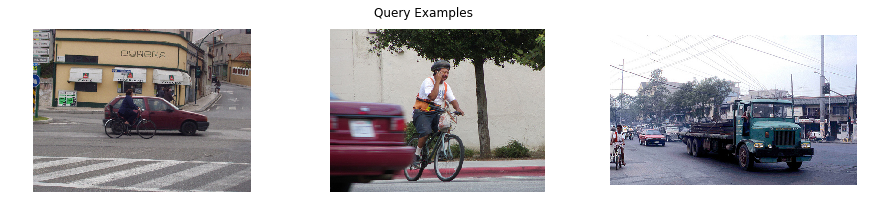

In [4]:
loader.show_examples(annotated=False, label=1)

...and some **negative** examples.

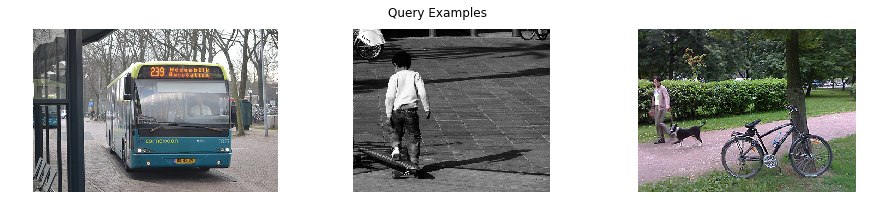

In [5]:
loader.show_examples(annotated=False, label=-1)

## 3. Write Labeling Functions (LFs)
We now develop LFs that take different primitives in as inputs and apply a label based on the value of those primitives. Notice that each of these LFs are "weak"— they aren't fully precise, and they don't have complete coverage.

Below, we have incldue the intuition that explains each of the LFs: 
* `LF_street`: If the image has a human and a road, we think a person might be riding a bike. 
* `LF_vechicles`: If the image has a human and a vehicle, we think a person might be riding a bike.
* `LF_distance`: If the image has a human and bike close to one another, we think that a person might be riding a bike. 
* `LF_size`: If the image has a human/bike around the same size (perhaps they're both in the foreground or background), we think a person might be riding a bike. 
* `LF_number`: If the image has the same number of bicycles and humans (i.e. _primitive_ categorized as `bike_human_num=2`) or there are fewer humans than bikes (i.e. `bike_human_num=0`), we think a person might be riding a bike.

**Assign Labeling Functions**

We create a list of the functions we used in `L_fns` and apply the labeling functions to the appropriate primitives to generate `L`, a _labeling matrix_.

_Note_: We usually have Snorkel manage our data using its ORM database backend, in which case we use the `LabelAnnotator` from the `snorkel.annotations` [module](http://snorkel.readthedocs.io/en/master/annotations.html#snorkel.annotations.LabelAnnotator). In this tutorial, we show how to explicitly construct labeling matrices manually, which can be useful when managing your data outside of Snorkel, as is the case with our image data!

In [13]:
L_fns = [LF_street,LF_vehicles,LF_distance,LF_size,LF_number]

L = np.zeros((len(L_fns),loader.train_num)).astype(int)
for i in range(loader.train_num):
    L[0,i] = L_fns[0](p_keys['has_human'][i], p_keys['has_road'][i])
    L[1,i] = L_fns[1](p_keys['has_human'][i], p_keys['has_cars'][i])
    L[2,i] = L_fns[2](p_keys['has_human'][i], p_keys['has_bike'][i], p_keys['bike_human_distance'][i])
    L[3,i] = L_fns[3](p_keys['has_human'][i], p_keys['has_bike'][i], p_keys['bike_human_size'][i])
    L[4,i] = L_fns[4](p_keys['has_human'][i], p_keys['has_bike'][i], p_keys['bike_human_num'][i])

**Calculate and Show Accuracy and Coverage of Labeling Functions**

Notice that while the labeling functions were intuitive for humans to write, they do not perform particularly well on their own. _Hint_: this is where the magic of Snorkel's generative model comes in!

_Note_: we define _coverage_ as the proportion of samples from which an LF does not abstain. Recall that each "uncertain" labeling function assigns `0`.

In [14]:
total = float(loader.train_num)

stats_table = np.zeros((len(L),2))
for i in range(len(L)):
    # coverage: (num labeled) / (total)
    stats_table[i,0] = np.sum(L[i,:] != 0)/ total
    
    # accuracy: (num correct assigned labels) / (total assigned labels)
    stats_table[i,1] = np.sum(L[i,:] == loader.train_ground)/float(np.sum(L[i,:] != 0))

In [15]:
import pandas as pd
stats_table = pd.DataFrame(stats_table, index = [lf.__name__ for lf in L_fns], columns = ["Coverage", "Accuracy"])
stats_table

Coverage  Accuracy
LF_street    0.444075  0.663342
LF_vehicles  0.444075  0.680798
LF_distance  0.609081  0.747273
LF_size      0.573643  0.770270
LF_number    0.712071  0.690513

## 4. Generate Training Set
At this point, we can take advantage of Snorkel's generative model to aggregate labels from our noisy labeling functions. 

In [16]:
from snorkel.learning import GenerativeModel
from scipy import sparse
import matplotlib.pyplot as plt

L_train = sparse.csr_matrix(L.T)

**Majority Vote**

To get a sense of how well our labeling functions perform when aggregated, we calcuate the accuracy of the training set labels if we took the majority vote label for each data point. This gives us a baseline for comparison against Snorkel's generative model.

In [17]:
mv_labels = np.sign(np.sum(L.T,1))
print ('Coverage of Majority Vote on Train Set: ', np.sum(np.sign(np.sum(np.abs(L.T),1)) != 0)/float(loader.train_num))
print ('Accuracy of Majority Vote on Train Set: ', np.sum(mv_labels == loader.train_ground)/float(loader.train_num))

Coverage of Majority Vote on Train Set:  1.0
Accuracy of Majority Vote on Train Set:  0.6744186046511628


**Generative Model**
For the Snorkel generative model, we assume that the labeling functions are conditionally independent given the true label. We train the generative model using the labels assigned by the labeling functions. 

For more advanced modeling of generative structure (i.e. using dependencies between primitives), refer to the Coral paradigm, as described in [Varma et. al 2017](https://arxiv.org/abs/1709.02477).

In [18]:
gen_model = GenerativeModel()

gen_model.train(L.T, epochs=100, decay=0.95, step_size= 0.01/ L.shape[1], reg_param=1e-6)
train_marginals = gen_model.marginals(L_train)

Inferred cardinality: 2


**Probabilistic Label Statistics**

We view the distribution of weak labels produced by our generative model. 

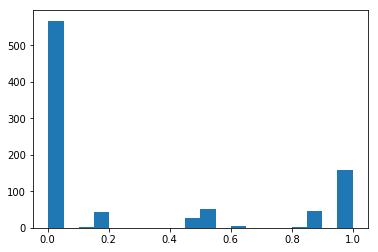

In [19]:
plt.hist(train_marginals, bins=20)
plt.show()

We can also compare the **empirical** accuracies of our labeling functions to the **learned** accuracies of our generative model over the validation data. 

In [20]:
learned_table = gen_model.learned_lf_stats()
empirical_acc = stats_table.values[:, 1]
learned_acc = learned_table.values[:,0]
compared_stats = pd.DataFrame(np.stack((empirical_acc, learned_acc)).T,
                             index = [lf.__name__ for lf in L_fns],
                             columns=['Empirical Acc.', 'Learned Acc.'])

compared_stats

Empirical Acc.  Learned Acc.
LF_street          0.663342      0.857026
LF_vehicles        0.680798      0.854854
LF_distance        0.747273      0.879654
LF_size            0.770270      0.879799
LF_number          0.690513      0.883487

_Note_: Coverage still refers to our model's tendency abstention from assigning labels to examples in the dataset. In this case, Snorkel's generative model has full coverage as it generalizes the labeling functions— it never assigns the "uncertain" label of 0.5.

In [21]:
labels = 2 * (train_marginals > 0.9) - 1
print ('Coverage of Generative Model on Train Set:', np.sum(train_marginals != 0.5)/float(len(train_marginals)))
print ('Accuracy of Generative Model on Train Set:', np.mean(labels == loader.train_ground))

Coverage of Generative Model on Train Set: 1.0
Accuracy of Generative Model on Train Set: 0.7486157253599114


Take note that with Snorkel's generative model, we're able to achieve a much higher accuracy than with majority vote over the labeling functions!

## Now, train a discriminative model with your weak labels! 
You can then use these training labels to train any standard discriminative model, such as [a state-of-the-art ResNet](https://github.com/KaimingHe/deep-residual-networks), which should learn to generalize beyond the LF's we've developed!

The only change needed from standard procedure is to deal with the fact that the training labels Snorkel generates are _probabilistic_ (i.e. for the binary case, in [0,1])— luckily, this is a one-liner in most modern ML frameworks! For example, in TensorFlow, you can use the [cross-entropy loss](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits).